# Action value method

## sample average value updates

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_experiment(game_len, n_bandits, epsilon, scale, n_runs):
    optimal_counts = np.zeros(game_len)
    rewards = np.zeros(game_len)

     
    for i in tqdm(range(n_runs)):
        q_true = np.random.normal(0, scale, size=n_bandits)
        optimal_bandit = np.argmax(q_true)
        q_estimates = np.zeros(n_bandits)
        n_plays = np.zeros(n_bandits)

        for j in range(game_len):
            if np.random.random() < epsilon:
                a = np.random.choice(n_bandits)
            else:
                a = np.argmax(q_estimates)

            if a == optimal_bandit:
                optimal_counts[j] += 1

            reward = np.random.normal(q_true[a], scale)
            rewards[j] += reward

            n_plays[a] += 1
            q_estimates[a] += (1/n_plays[a]) * (reward - q_estimates[a])

    rewards /= n_runs
    optimal_counts /= n_runs

    plt.subplot(2, 1, 1)
    plt.plot(rewards)
    plt.ylabel('Average reward')

    plt.subplot(2, 1, 2)
    plt.plot(optimal_counts)
    plt.ylabel('% Optimal action')
    plt.xlabel('Step')

    plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 275.17it/s]


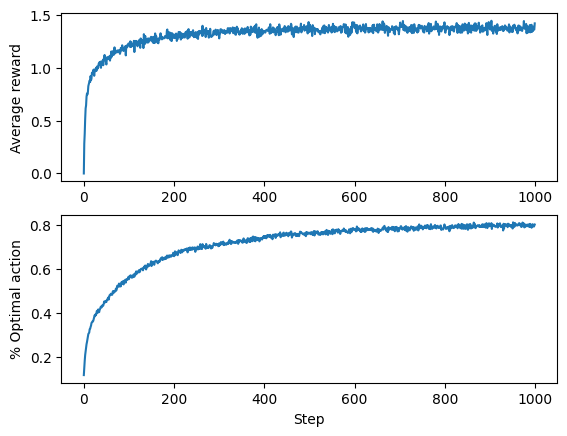

In [8]:
game_len = 1000
n_bandits = 10
epsilon = 0.1
scale = 1.0
n_runs = 2000

run_experiment(game_len, n_bandits, epsilon, scale, n_runs)

## Learning rate value updates

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_experiment(game_len, n_bandits, epsilon, scale, n_runs, alpha):
    optimal_counts = np.zeros(game_len)
    rewards = np.zeros(game_len)

     
    for i in tqdm(range(n_runs)):
        q_true = np.random.normal(0, scale, size=n_bandits)
        optimal_bandit = np.argmax(q_true)
        q_estimates = np.zeros(n_bandits)
        n_plays = np.zeros(n_bandits)

        for j in range(game_len):
            if np.random.random() < epsilon:
                a = np.random.choice(n_bandits)
            else:
                a = np.argmax(q_estimates)

            if a == optimal_bandit:
                optimal_counts[j] += 1

            reward = np.random.normal(q_true[a], scale)
            rewards[j] += reward

            n_plays[a] += 1
            q_estimates[a] += alpha * (reward - q_estimates[a])

    rewards /= n_runs
    optimal_counts /= n_runs

    plt.subplot(2, 1, 1)
    plt.plot(rewards)
    plt.ylabel('Average reward')

    plt.subplot(2, 1, 2)
    plt.plot(optimal_counts)
    plt.ylabel('% Optimal action')
    plt.xlabel('Step')

    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 296.68it/s]


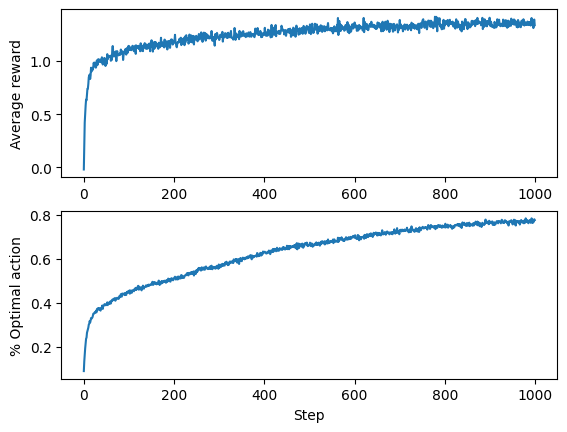

In [13]:
game_len = 1000
n_bandits = 10
epsilon = 0.1
scale = 1.0
n_runs = 2000
alpha = 0.1

run_experiment(game_len, n_bandits, epsilon, scale, n_runs, alpha)

## Upper-Confidence-Bound action selection

In [53]:
def run_experiment_ucb(game_len, n_bandits, c, scale, n_runs):
    optimal_counts = np.zeros(game_len)
    rewards = np.zeros(game_len)

    for i in tqdm(range(n_runs)):
        q_true = np.random.normal(0, scale, size=n_bandits)
        optimal_bandit = np.argmax(q_true)
        q_estimates = np.zeros(n_bandits)
        n_plays = np.zeros(n_bandits)

        for j in range(game_len):
            if np.sum(n_plays) < n_bandits:
                a = np.random.choice(n_bandits)
            else:
                a = np.argmax(q_estimates + c * np.sqrt(np.log(j+1)/(n_plays+1e-6)))

            if a == optimal_bandit:
                optimal_counts[j] += 1

            reward = np.random.normal(q_true[a], scale)
            rewards[j] += reward

            n_plays[a] += 1
            q_estimates[a] += (1/n_plays[a]) * (reward - q_estimates[a])

    rewards /= n_runs
    optimal_counts /= n_runs

    plt.subplot(2, 1, 1)
    plt.plot(rewards)
    plt.ylabel('Average reward')

    plt.subplot(2, 1, 2)
    plt.plot(optimal_counts)
    plt.ylabel('% Optimal action')
    plt.xlabel('Step')

    plt.show()



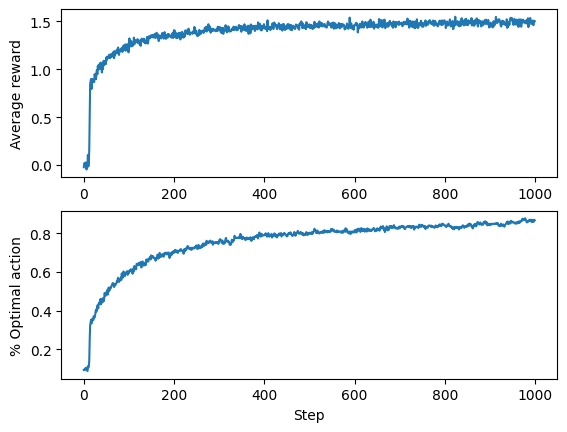

In [54]:
game_len = 1000
n_bandits = 10
c = 2
scale = 1.0
n_runs = 2000

run_experiment_ucb(game_len, n_bandits, c, scale, n_runs)



## Gradient Bandit Algorithms

Unlike the mothods before, the gradient bandit algorithm doesn't try to estimate action values but instead learns to prefer one choice over another. In other words this is an action preference model.  

Under this model we can numerically compare the preference of one action over another in a given state but we have no way of knowing the relative value or reward such an action could yield.


We generally denote this preference function as $H_t(a)$ and we can calculate the probability of taking an action as the softmax over all actions of $H_t(a)$ (denoted $\pi_t(a)$:

$\pi_t(a) = \frac{e^{H_t(a)}}{\sum{e^{H_t}}}$

which is euler's number raised to the preference of the action devided by the sum over the same expression for all actions

In [ ]:
import numpy as np

class GradientBandit:
    def __init__(self, n_bandits, alpha, baseline=False):
        self.n_bandits = n_bandits
        self.alpha = alpha
        self.baseline = baseline
        self.preferences = np.zeros(n_bandits)

        self.action_probs = np.ones(n_bandits) / n_bandits

        self.rewards = []
        self.actions = []

    def select_action(self):
        self.action_probs = np.exp(self.preferences) / np.sum(np.exp(self.preferences))
        return np.random.choice(self.n_bandits, p=self.action_probs)

    def update(self, action, reward):
        self.rewards.append(reward)
        self.actions.append(action)

        if self.baseline:
            baseline = np.mean(self.rewards)
        else:
            baseline = 0

        for i in range(self.n_bandits):
            if i == action:
                self.preferences[i] += self.alpha * (reward - baseline) * (1 - self.action_probs[i])
            else:
                self.preferences[i] -= self.alpha * (reward - baseline) * self.action_probs[i]



In [60]:
def run_experiment(game_len, n_bandits, alpha, n_runs, baseline=False):
    optimal_counts = np.zeros(game_len)
    rewards = np.zeros(game_len)

    for i in range(n_runs):
        q_true = np.random.normal(0, scale, size=n_bandits)
        optimal_bandit = np.argmax(q_true)

        bandit = GradientBandit(n_bandits, alpha, baseline)

        for j in range(game_len):
            action = bandit.select_action()

            if action == optimal_bandit:
                optimal_counts[j] += 1

            reward = np.random.normal(q_true[action], scale)
            rewards[j] += reward

            bandit.update(action, reward)

    rewards /= n_runs
    optimal_counts /= n_runs

    plt.subplot(2, 1, 1)
    plt.plot(rewards)
    plt.ylabel('Average reward')

    plt.subplot(2, 1, 2)
    plt.plot(optimal_counts)
    plt.ylabel('% Optimal action')
    plt.xlabel('Step')

    plt.show()


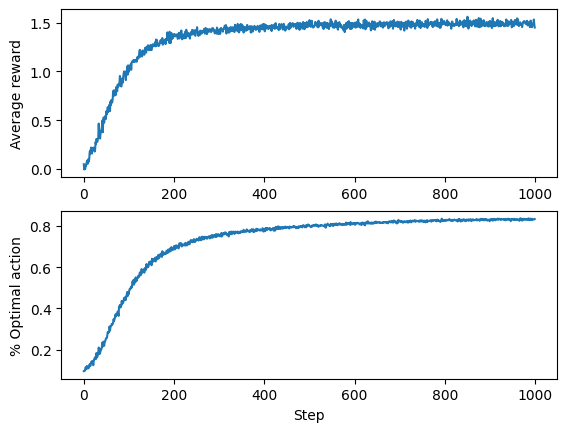

In [62]:
game_len = 1000
n_bandits = 10
alpha = 0.1
n_runs = 2000
baseline = False

run_experiment(game_len, n_bandits, alpha, n_runs, baseline)